# Full-Sequence Panorama Construction
This notebook extends our 2-image homography example to the complete ordered sequence in a folder.

## Pipeline
1. Load and sort images from a folder.
2. Detect keypoints/descriptors (SIFT).
3. Match descriptors between consecutive pairs using Lowe's ratio test.
4. Estimate pairwise homographies with RANSAC (consecutive frames).
5. Chain homographies to a reference frame (center image) to minimize distortion.
6. Warp all images into the common reference coordinate system.
7. Perform simple Gaussian-weighted blending to form the panorama.

In [1]:
# Global imports and configuration
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from typing import List, Dict

plt.rcParams['figure.figsize'] = [15, 10]
np.set_printoptions(precision=3, suppress=True)

### 1. Load, Sort and Resize Images

In [2]:
MAX_WIDTH = 1280
MAX_HEIGHT = 720
image_folder = '../data/rio_niteroi_scene/'

images: List[np.ndarray] = []
image_names: List[str] = []

print(f'Searching images in: {os.path.abspath(image_folder)}')
for filename in sorted(os.listdir(image_folder)):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        p = os.path.join(image_folder, filename)
        img = cv2.imread(p)
        if img is not None:
            # Simple orientation-adjusted resize keeping uniform size for the pipeline
            if img.shape[0] > img.shape[1]:
                tmp = MAX_WIDTH
                MAX_WIDTH = MAX_HEIGHT
                MAX_HEIGHT = tmp
            img = cv2.resize(img, (MAX_WIDTH, MAX_HEIGHT))
            images.append(img)
            image_names.append(filename)
        else:
            print(f'Failed to load: {filename}')

print(f'Total images: {len(images)}')
assert len(images) >= 2, 'At least 2 images are required.'

Searching images in: /Users/mengo/Documents/Doutorado/2025s2/MO446/T1/data/rio_niteroi_scene
Total images: 5
Total images: 5


### 2. Detect Local Features (SIFT)
We extract scale- and rotation-invariant keypoints using SIFT. Each keypoint has a descriptor (128-D vector) capturing local gradient structure.

Design considerations:
- nfeatures limits max keypoints to control runtime.
- Contrast/edge thresholds could be tuned for low-texture scenes.
- Alternative detectors (ORB/AKAZE) can also be introduced.

In [3]:
# Detector/Descriptor (SIFT) and FLANN matcher
sift = cv2.SIFT_create(nfeatures=1500)

# FLANN for SIFT descriptors (float32) using KDTree
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

ratio_thresh = 0.85  # Lowe's ratio threshold

In [4]:
def detect_all_features(imgs: List[np.ndarray]) -> List[Dict]:
    """Detect SIFT keypoints/descriptors for all images.

    Returns a list of dicts with keys: 'image', 'gray', 'kp', 'desc'.
    """
    data = []
    for i, im in enumerate(imgs):
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        kp, desc = sift.detectAndCompute(gray, None)
        data.append({'image': im, 'gray': gray, 'kp': kp, 'desc': desc})
        print(f'Image {i}: {image_names[i]} | keypoints: {len(kp)} | desc: {None if desc is None else desc.shape}')
    return data

dataset = detect_all_features(images)
print(f'Dataset created with {len(dataset)} images.')

Image 0: IMG_3145.jpeg | keypoints: 1500 | desc: (1500, 128)
Image 1: IMG_3146.jpeg | keypoints: 1501 | desc: (1501, 128)
Image 2: IMG_3147.jpeg | keypoints: 1500 | desc: (1500, 128)
Image 1: IMG_3146.jpeg | keypoints: 1501 | desc: (1501, 128)
Image 2: IMG_3147.jpeg | keypoints: 1500 | desc: (1500, 128)
Image 3: IMG_3148.jpeg | keypoints: 1500 | desc: (1500, 128)
Image 3: IMG_3148.jpeg | keypoints: 1500 | desc: (1500, 128)
Image 4: IMG_3149.jpeg | keypoints: 1500 | desc: (1500, 128)
Dataset created with 5 images.
Image 4: IMG_3149.jpeg | keypoints: 1500 | desc: (1500, 128)
Dataset created with 5 images.


### 3. Match Consecutive Image Pairs
We perform descriptor matching only between consecutive frames to keep graph topology simple (a path). For each descriptor in image i we retrieve its 2 nearest neighbors in image i+1 and apply Lowe's ratio test.

Rationale:
- Restricting to adjacent images reduces false matches and runtime.
- Full graph matching (all-vs-all) improves robustness for unordered sets but is O(N^2).
- Lowe ratio threshold (typical 0.7–0.9) trades precision vs recall.

In [5]:
def match_pair(desc1: np.ndarray, desc2: np.ndarray):
    """Return list of good matches between two descriptor sets using KNN + Lowe ratio test."""
    if desc1 is None or desc2 is None:
        return []
    # KNN + Lowe ratio test
    knn = flann.knnMatch(desc1, desc2, k=2)
    good = []
    for m, n in knn:
        if m.distance < ratio_thresh * n.distance:
            good.append(m)
    return good

pairs_matches = []
for i in range(len(dataset) - 1):
    m = match_pair(dataset[i]['desc'], dataset[i+1]['desc'])
    print(f'Pair ({i},{i+1}) -> filtered matches: {len(m)}')
    pairs_matches.append(m)

# Quick sanity check
assert all(len(m) >= 4 for m in pairs_matches), 'A pair has insufficient matches (>=4 required) for homography.'

Pair (0,1) -> filtered matches: 578
Pair (1,2) -> filtered matches: 495
Pair (2,3) -> filtered matches: 498
Pair (3,4) -> filtered matches: 504


### 4. Estimate Pairwise Homographies (RANSAC)
Using the filtered matches for each adjacent pair we compute a projective transform (3x3 homography) with RANSAC to reject outliers.

Parameters:
- ransacReprojThreshold: maximum reprojection error (pixels) to count as inlier.
- maxIters, confidence: control robustness vs speed.

Failure modes:
- Too few inliers (low texture / motion blur).
- Pure rotation + low parallax may still produce valid H but can amplify drift when chaining.

In [6]:
def estimate_homography_between(i: int, j: int):
    """Estimate homography mapping image i to image j (only consecutive supported)."""
    kpA, kpB = dataset[i]['kp'], dataset[j]['kp']
    matches = pairs_matches[i] if j == i+1 else None
    if matches is None:
        raise ValueError('This example only estimates between consecutive pairs.')
    ptsA = np.float32([kpA[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    ptsB = np.float32([kpB[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    H, inliers = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC, ransacReprojThreshold=3.0, maxIters=2000, confidence=0.995)
    if H is None:
        raise RuntimeError(f'Failed to estimate H between {i}->{j}')
    nin = int(inliers.sum()) if inliers is not None else 0
    print(f'H {i}->{j} estimated. Inliers: {nin}/{len(matches)}')
    return H

# H_forward[i] maps i -> i+1
H_forward: List[np.ndarray] = []
for i in range(len(dataset) - 1):
    H = estimate_homography_between(i, i+1)
    H = H / H[2,2]
    print(f'H_{i}->{i+1}:{H}')
    H_forward.append(H)

H 0->1 estimated. Inliers: 474/578
H_0->1:[[   1.457   -0.111 -460.926]
 [   0.181    1.259 -127.661]
 [   0.      -0.       1.   ]]
H 1->2 estimated. Inliers: 390/495
H_1->2:[[   1.583   -0.035 -598.582]
 [   0.177    1.352 -120.53 ]
 [   0.      -0.       1.   ]]
H 2->3 estimated. Inliers: 397/498
H_2->3:[[   1.352   -0.035 -384.873]
 [   0.11     1.185  -54.461]
 [   0.      -0.       1.   ]]
H 3->4 estimated. Inliers: 401/504
H_3->4:[[   1.347   -0.128 -345.59 ]
 [   0.161    1.176  -85.001]
 [   0.      -0.       1.   ]]


### 5. Chain Homographies to a Reference Frame
We choose the middle image as reference to minimize perspective distortion and accumulated drift. For images left of the reference we compose forward homographies; for the right side we compose then invert.

Alternative strategies:
- Global bundle adjustment optimizing all homographies simultaneously.
- Selecting a frame with minimal average distance to others (graph center).

In [7]:
def chain_homographies_to_ref(n: int, ref_idx: int, H_forward: List[np.ndarray]) -> List[np.ndarray]:
    """Return list H_to_ref[k]: homography mapping image k into reference frame ref_idx."""
    I = np.eye(3, dtype=np.float64)
    H_to_ref = [I.copy() for _ in range(n)]
    # For k < ref: multiply forward (k->k+1->...->ref)
    for k in range(ref_idx - 1, -1, -1):
        H_to_ref[k] = H_forward[k] @ H_to_ref[k+1]
        H_to_ref[k] /= H_to_ref[k][2,2]
    # For k > ref: chain ref->...->k then invert
    for k in range(ref_idx + 1, n):
        H_ref_to_k = np.eye(3, dtype=np.float64)
        for t in range(ref_idx, k):
            H_ref_to_k = H_forward[t] @ H_ref_to_k
        H_to_ref[k] = np.linalg.inv(H_ref_to_k)
        H_to_ref[k] /= H_to_ref[k][2,2]
    return H_to_ref

ref_idx = len(dataset) // 2  # central image as reference
H_to_ref = chain_homographies_to_ref(len(dataset), ref_idx, H_forward)
print(f'Reference image: {ref_idx} -> {image_names[ref_idx]}')

Reference image: 2 -> IMG_3147.jpeg


#### Computing panorama canvas bounds from warped corners

In [8]:
def compute_panorama_bounds(imgs: List[np.ndarray], H_to_ref: List[np.ndarray]):
    corners_all = []
    for k, img in enumerate(imgs):
        h, w = img.shape[:2]
        corners = np.float32([[0,0],[w,0],[w,h],[0,h]]).reshape(-1,1,2)
        warped = cv2.perspectiveTransform(corners, H_to_ref[k])
        corners_all.append(warped)
    allc = np.vstack(corners_all)
    xmin, ymin = np.floor(allc.min(axis=0).ravel()).astype(int)
    xmax, ymax = np.ceil(allc.max(axis=0).ravel()).astype(int)
    return xmin, ymin, xmax, ymax

xmin, ymin, xmax, ymax = compute_panorama_bounds(images, H_to_ref)
Tx, Ty = -xmin, -ymin
T = np.array([[1,0,Tx],[0,1,Ty],[0,0,1]], dtype=np.float64)
W, Hh = (xmax - xmin), (ymax - ymin)
print(f'Panorama canvas (W x H): {W} x {Hh}')

Panorama canvas (W x H): 4452 x 1668


### 6. Warp Images to Common Reference Frame

--- Showing progressive alignment of each image on the final canvas ---


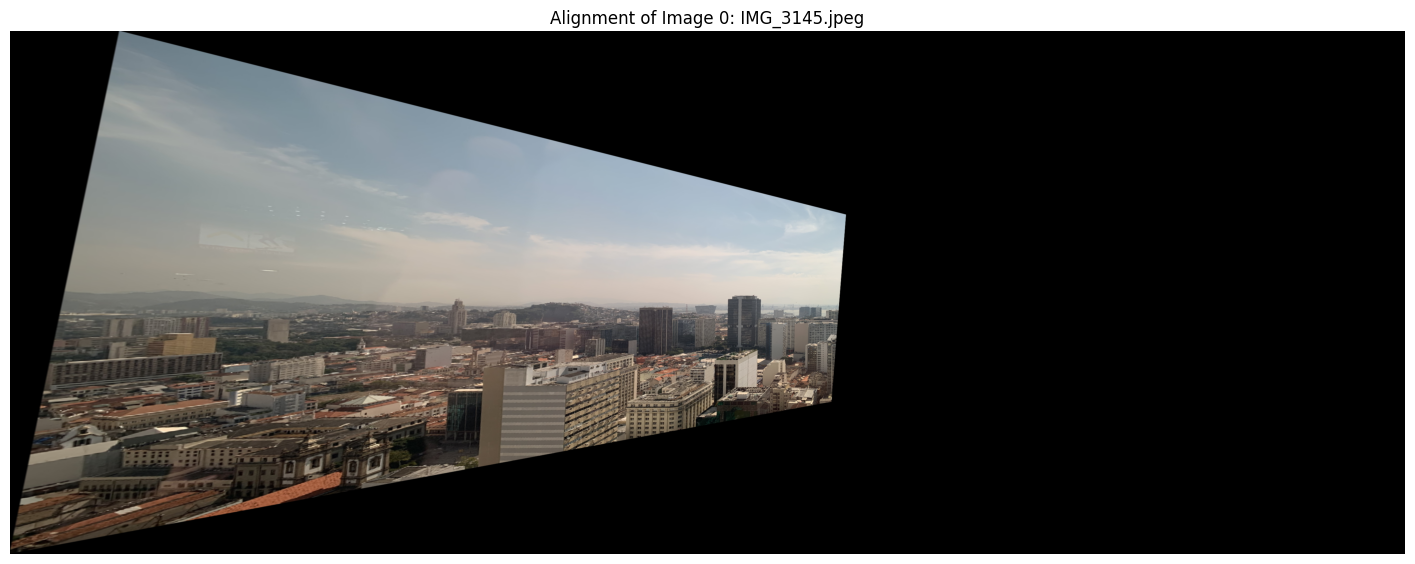

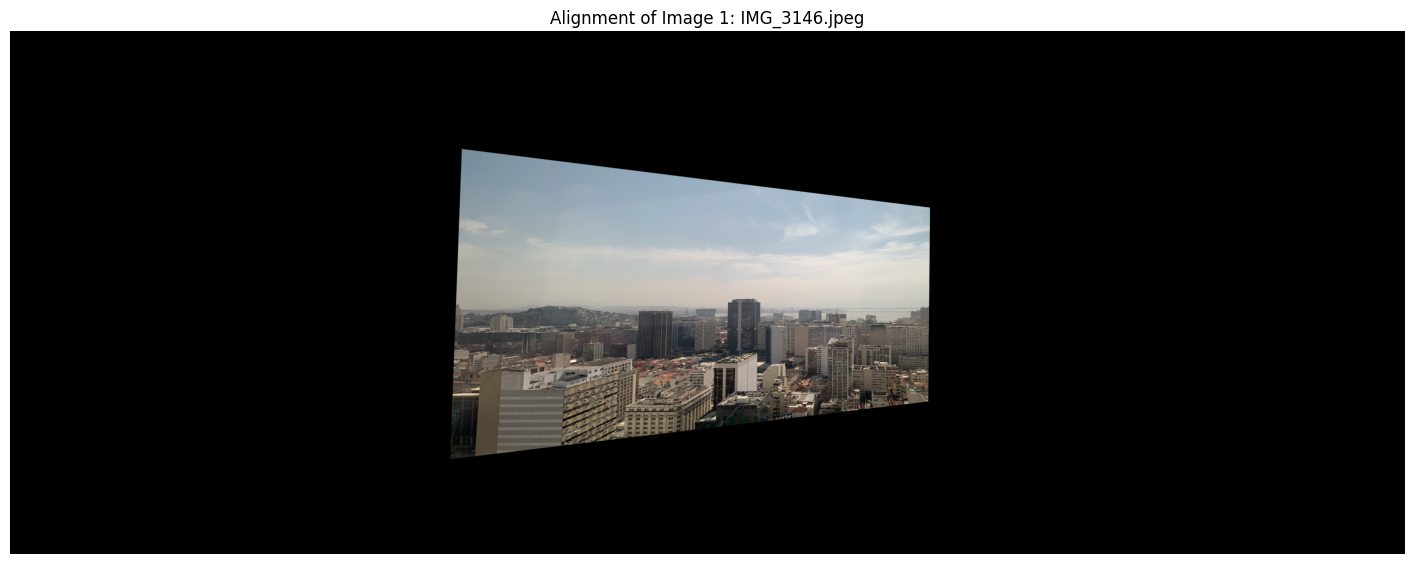

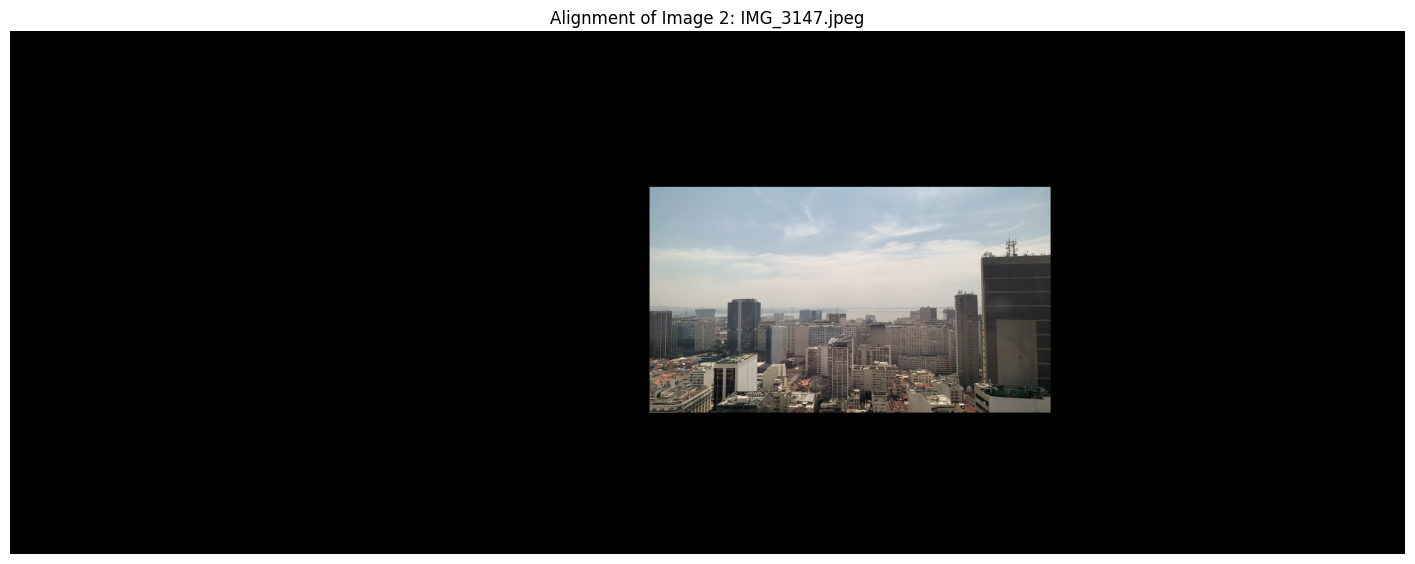

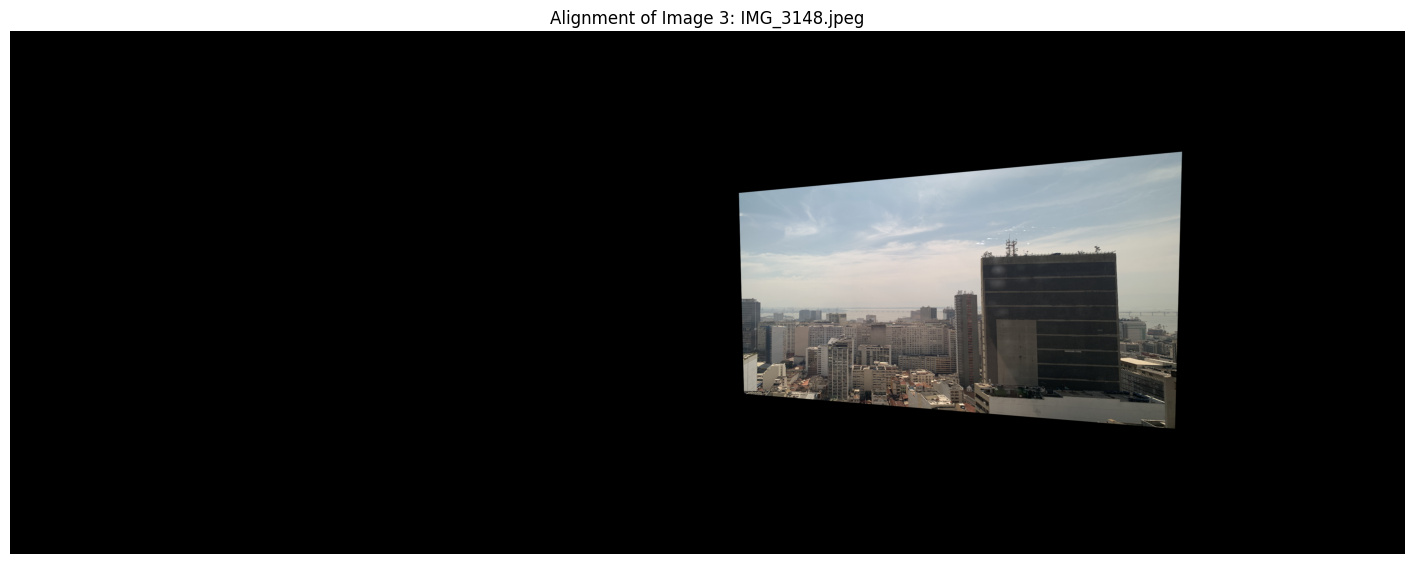

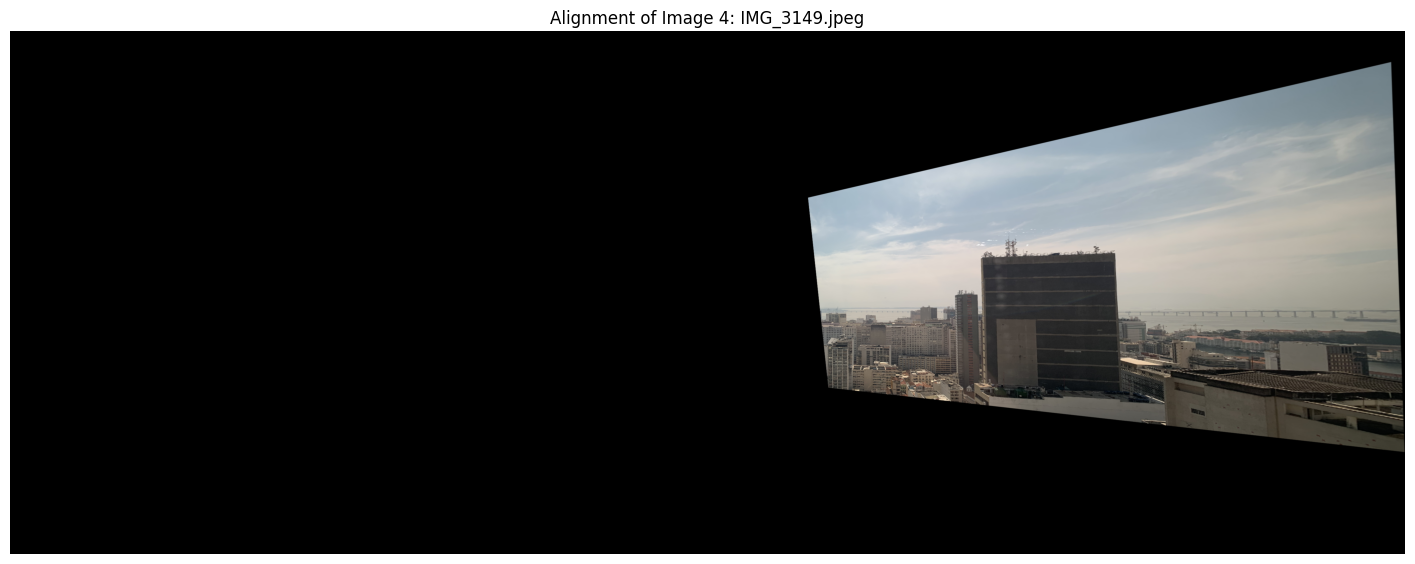

In [ ]:
print('--- Showing progressive alignment of each image on the final canvas ---')
for k, img in enumerate(images):
    # Transformation for image k: translation T composed with homography H_to_ref[k]
    Hk = T @ H_to_ref[k]
    # Warp the k-th image into the panorama canvas
    warped_image = cv2.warpPerspective(img, Hk, (W, Hh))
    # Display the aligned image
    plt.figure(figsize=(18,10))
    plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Alignment of Image {k}: {image_names[k]}')
    plt.axis('off')
    plt.show()

### 7. Naive Gaussian Blending

In [13]:
SIGMA = 1

# Warp + simple Gaussian-weighted blending
def warp_and_blend(imgs: List[np.ndarray], H_to_ref: List[np.ndarray], T: np.ndarray, size: tuple, sigma: int = 1):
    """Warp all images into panorama canvas and blend with blurred mask weighting."""
    W, Hh = size
    acc = np.zeros((Hh, W, 3), dtype=np.float64)
    wsum = np.zeros((Hh, W, 1), dtype=np.float64)
    for k, img in enumerate(imgs):
        Hk = T @ H_to_ref[k]
        warped = cv2.warpPerspective(img, Hk, (W, Hh))
        mask = np.ones(img.shape[:2], dtype=np.uint8) * 255
        warped_mask = cv2.warpPerspective(mask, Hk, (W, Hh))
        weight = warped_mask.astype(np.float32) / 255.0
        if sigma and sigma > 1:
            ksize = (sigma | 1, sigma | 1)  # ensure odd size
            weight = cv2.GaussianBlur(weight, ksize, 0)
        weight = weight[..., None]
        acc += warped.astype(np.float64) * weight
        wsum += weight
    eps = 1e-6
    out = (acc / (wsum + eps)).clip(0, 255).astype(np.uint8)
    return out

panorama = warp_and_blend(images, H_to_ref, T, (W, Hh), sigma=SIGMA)

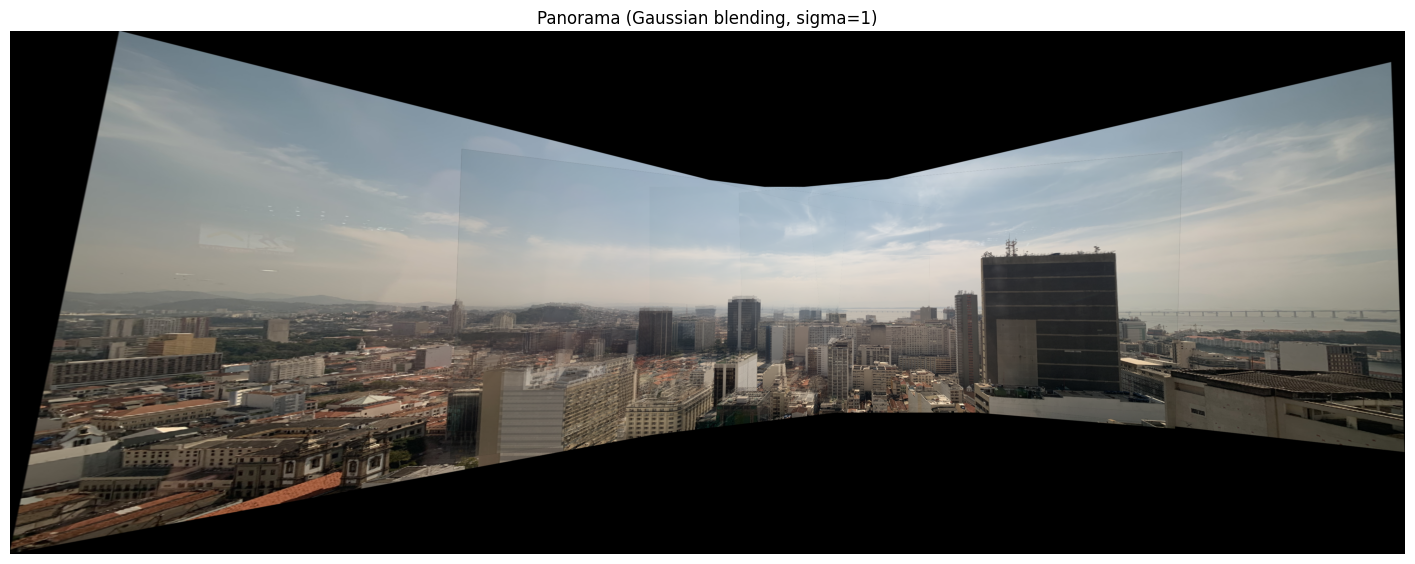

In [14]:
plt.figure(figsize=(18,10))
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.title(f'Panorama (Gaussian blending, sigma={SIGMA})')
plt.axis('off')
plt.show()